In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
device = 'cuda:0'
torch.manual_seed(0)
torch.cuda.is_available()

True

In [2]:
opt = {
    "num_atoms":10,
    "hidden_size": 100,
    "simulate": 1000
}

In [3]:
# Force Field
class ForceField(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ForceField, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

In [4]:
# Atom Coordinates
class AtomCoordinates(nn.Module):
    def __init__(self, num_atoms):
        super(AtomCoordinates, self).__init__()
        self.coordinates = nn.Parameter(torch.randn(num_atoms))

    def forward(self):
        return self.coordinates

In [5]:
# Data
def lennard_jones_potential(r, eps=1e-1):
    return 1.5**12 / (r+eps)**12 - 1.5**6 / (r+eps)**6
#     return 1 / (r+eps)**12 - 1 / (r+eps)**6

def distances_matrix(coordinates):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates.view(-1, 1), coordinates.view(-1, 1))
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]
    return distances

def simulate_stable_conformations(atom_coordinates, force_field, num_iterations=100, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates).view(-1, 1)))

        optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 1000 == -1:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

    return atom_coordinates

In [6]:
# Train
def train(force_field, atom_coordinates, num_iterations=1000):
    atom_optimizer = optim.Adam(atom_coordinates.parameters(), lr=0.01)
    force_optimizer = optim.Adam(force_field.parameters(), lr=0.01)
    
    for iteration in range(num_iterations): 
        # MD Simulation
        if iteration % opt["simulate"] == 0:
            atom_stable = AtomCoordinates(opt["num_atoms"])
            stable_conformations = simulate_stable_conformations(atom_stable(), lennard_jones_potential, num_iterations=opt["simulate"])
    
        # Atom Coordinates
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates.coordinates).view(-1, 1)))
        atom_optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates.parameters(), 0.1)
        atom_optimizer.step()

        # Force Field
        tempor_conformations = atom_coordinates.coordinates.clone().detach()
        temp_energy = torch.sum(force_field(distances_matrix(tempor_conformations).view(-1, 1)))        
        true_energy = torch.sum(force_field(distances_matrix(stable_conformations).view(-1, 1)))
        energy_difference = true_energy - temp_energy
        loss_energy = energy_difference + torch.abs(torch.mean(force_field(torch.arange(0.5, 50., 0.1).view(-1, 1))))
        force_optimizer.zero_grad()
        loss_energy.backward()
        torch.nn.utils.clip_grad_norm_(force_field.parameters(), 0.1)
        force_optimizer.step()        

        # Print progress
        if iteration % 1000 == 0:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()},  Energy Difference: {energy_difference.item()}")

In [7]:
atom_coordinates = AtomCoordinates(opt["num_atoms"])
force_field = ForceField(1, opt["hidden_size"], 1)
train(force_field, atom_coordinates, 30000)

Iteration 0, Potential Energy: -8.600998878479004,  Energy Difference: -1.2019577026367188
Iteration 1000, Potential Energy: -49.40678405761719,  Energy Difference: 0.9604377746582031
Iteration 2000, Potential Energy: -57.649513244628906,  Energy Difference: 0.3620147705078125
Iteration 3000, Potential Energy: -43.9794921875,  Energy Difference: 1.6466064453125
Iteration 4000, Potential Energy: -36.20283126831055,  Energy Difference: 0.120819091796875
Iteration 5000, Potential Energy: -24.38785171508789,  Energy Difference: -0.12615585327148438
Iteration 6000, Potential Energy: -19.010162353515625,  Energy Difference: 0.40885353088378906
Iteration 7000, Potential Energy: -19.279098510742188,  Energy Difference: -0.28824615478515625
Iteration 8000, Potential Energy: -21.205514907836914,  Energy Difference: 0.3202629089355469
Iteration 9000, Potential Energy: -14.646794319152832,  Energy Difference: -0.1769733428955078
Iteration 10000, Potential Energy: -12.17697811126709,  Energy Differ

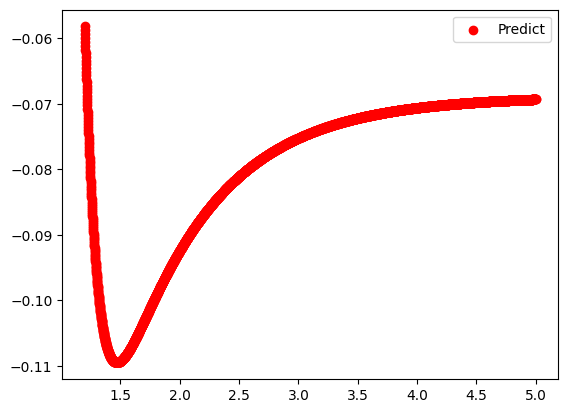

In [18]:
x_data = torch.arange(1.2, 5.0, 0.001)
y_real = lennard_jones_potential(x_data)
y_pred = force_field(x_data.view(-1, 1)).detach()

# plt.scatter(x_data.numpy(), y_real.numpy(), label='Real')
plt.scatter(x_data.numpy(), y_pred.numpy(), label='Predict', color='red')
plt.legend()
plt.show()

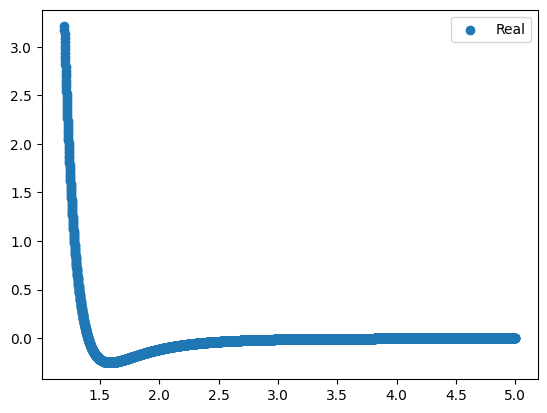

In [19]:
x_data = torch.arange(1.2, 5.0, 0.001)
y_real = lennard_jones_potential(x_data)
y_pred = force_field(x_data.view(-1, 1)).detach()

plt.scatter(x_data.numpy(), y_real.numpy(), label='Real')
# plt.scatter(x_data.numpy(), y_pred.numpy(), label='Predict', color='red')
plt.legend()
plt.show()

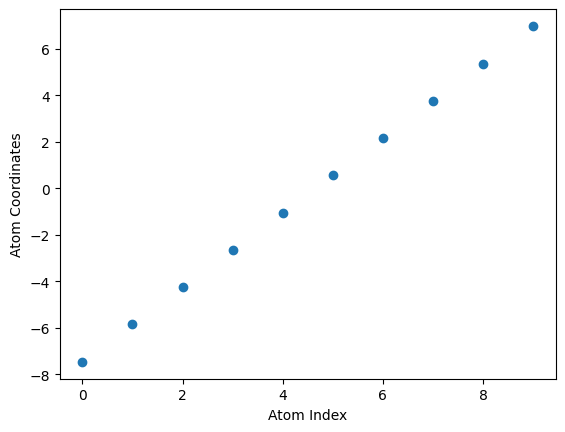

In [20]:
coordinates = atom_coordinates.coordinates.detach().numpy()

plt.scatter(range(len(coordinates)), np.sort(coordinates))
plt.xlabel('Atom Index')
plt.ylabel('Atom Coordinates')
plt.show()

In [ ]:
# Data
def lennard_jones_potential(r, eps=1e-1):
    return 1.5**12 / (r+eps)**12 - 1.5**6 / (r+eps)**6
#     return 1 / (r+eps)**12 - 1 / (r+eps)**6

def distances_matrix(coordinates):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates.view(-1, 1), coordinates.view(-1, 1))
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]
    return distances

def simulate_stable_conformations(atom_coordinates, force_field, num_iterations=100, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates).view(-1, 1)))

        optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 1000 == -1:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

    return atom_coordinates

In [ ]:
x_data = torch.arange(0.9, 5.0, 0.001)
y_real = lennard_jones_potential(x_data)
y_pred = force_field(x_data.view(-1, 1)).detach()

plt.scatter(x_data.numpy(), y_real.numpy(), label='Real')
# plt.scatter(x_data.numpy(), y_pred.numpy(), label='Predict', color='red')
plt.legend()
plt.show()

In [ ]:
# Data
def lennard_jones_potential(r, eps=1e-1):
    return 1 / (r+eps)**12 - 1 / (r+eps)**6

def distances_matrix(coordinates):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates.view(-1, 1), coordinates.view(-1, 1))
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]
    return distances

def simulate_stable_conformations(atom_coordinates, force_field, num_iterations=5000, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates).view(-1, 1)))

        optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 1000 == -1:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

    return atom_coordinates

In [ ]:
stable_coordinates = AtomCoordinates(opt["num_atoms"])
stable_conformations = simulate_stable_conformations(stable_coordinates(), lennard_jones_potential, num_iterations=5000)
coordinates = stable_conformations.data.numpy()

In [ ]:
plt.scatter(range(len(coordinates)), np.sort(coordinates))
plt.xlabel('Atom Index')
plt.ylabel('Atom Coordinates')
plt.title('1D Scatter Plot of Atom Coordinates')
plt.show()

In [ ]:
stable_coordinates = AtomCoordinates(100)
stable_conformations = simulate_stable_conformations(stable_coordinates(), force_field, num_iterations=1000)
coordinates = stable_conformations.data.numpy()

In [ ]:
plt.scatter(range(len(coordinates)), np.sort(coordinates))
plt.xlabel('Atom Index')
plt.ylabel('Atom Coordinates')
plt.title('1D Scatter Plot of Atom Coordinates')
plt.show()

In [ ]:
# Data
def lennard_jones_potential(r, eps=1e-1):
    return 1 / (r+eps)**12 - 1 / (r+eps)**6

def distances_matrix(coordinates):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates.view(-1, 1), coordinates.view(-1, 1))
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]
    return distances

def simulate_stable_conformations(atom_coordinates, force_field=lennard_jones_potential, num_iterations=1000, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates)))

        optimizer.zero_grad()
        potential_energy.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 500 == 0:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

    return atom_coordinates

In [ ]:
atom_coordinates()

In [ ]:
stable_conformations

In [ ]:
a = torch.tensor([1., 4., 7.])
b = torch.tensor([2., 3., 4.])
dis = torch.cdist(a.view(-1, 1), b.view(-1, 1))
print(dis)

In [ ]:
a = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = torch.tensor([[10, 10, 10], [10, 10, 10], [10, 10, 10]])
torch.tril(a, diagonal=-1) + torch.triu(b, diagonal=0)

In [ ]:
a.view(-1)

In [ ]:
# Create a square matrix
matrix_size = 5
matrix = torch.randn(matrix_size, matrix_size)

# Get the upper triangle indices
upper_triangle_indices = torch.triu_indices(matrix_size, matrix_size, offset=1)

# Slice the upper triangle of the matrix
upper_triangle_values = matrix[upper_triangle_indices[0], upper_triangle_indices[1]]

print("Original Matrix:")
print(matrix)

print("\nUpper Triangle Values:")
print(upper_triangle_values)